
## Nike Shoes Price Prediction


<a id="contents"></a>
## Table of Contents

- [**1. Introduction and Initial Project Question**](#goal)


- [**2. Data Description**](#description)


- [**3. Initial Data Collection and Cleaning**](#collection) 


- [**4. Visualizations and Captions**](#visualizations) 


- [**5. Baseline Model**](#models) 


- [**6. Final Conclusions**](#question) 


- [**7. References**](#references) 
  
  

<a id="goal"></a>

## 1. Introduction and Initial Project Question
[Return to Table of Contents](#contents)

The growth of online marketplaces represents a permanent change in how people buy and sell. As such, pricing products correctly on e-commerce platforms is crucial. Over-valued listings are met with strong resistance to liquidation, while under-valued items will not necessarily sell faster due to doubts about authenticity or quality, not to mention the forfeiture of profits. Product appraisal is no easy task and small details can make big differences in pricing. Predicting product prices at scale is a tremendous undertaking. 

This project analyzes Nike shoe data to gain an understanding of relationships between indicators such as product name, description, color, customer rating, and price. Let's see if descriptive characteristics provide any meaningful insights into the product’s price.


<a id="description"></a>

## 2. Data Description
[Return to Table of Contents](#contents)

Since the focus is predicting the Nike shoe prices, the two Kaggle data sets initially reviewed, but found to be too sparse in Nike models and features:

   1. Adidas VS Nike: https://www.kaggle.com/datasets/kaushiksuresh147/adidas-vs-nike, and 
   2. StockX Sneaker Data: https://www.kaggle.com/datasets/hudsonstuck/stockx-data-contest

Therefore, I opted for scraping our own data directly from https://www.nike.com/w/shoes-y7ok website by Python's Beautiful Soup package. Selenium webdriver was used for retrieving the page source of this website as it is dynamically generated through Lazy Loading. Scraped features are listed below."

- **model**: Shoe model (ex. Air Force 1)
- **category**: Shoe style (ex. Running, Jordan, Golf, etc)
- **gender_and_age**: Categorical data, gender represents 'women', 'men' and 'age' while age represents 'big kids', 'little kids', 'baby&toddler'
- **n_color**: number of colors used in the shoe model
- **short_description**: Nike's product marketing description
- **rating**: Buyer ratings bases on a 5 star rating system
- **n_reviews**:  Number of product reviews left by buyers
- **price**: Listed MSRP shoe price

<a id="collection"></a>

## 3. Initial Data Collection and Cleaning


<h4> Data cleaning steps: </h4>


<h5> General approaches: </h5>

1. Remove duplicated data
2. Find missing data and drop


<h5> On text based columns: </h5>

1. Lowercase the words

2. Expand contractions
    
3. Remove punctuations

4. Remove stopwords

5. Lemmatize
 
6. Create Document Term Matrix  by  sklearn's CountVectorizer

7. Find the most correlated words

In [1]:
# Imports and preferences
import json
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pickle
import time
import requests
import queue
import concurrent
from concurrent.futures import ThreadPoolExecutor
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from selenium import webdriver # pip install selenium might be required
from urllib.parse import urljoin
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from bs4 import BeautifulSoup
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.feature_extraction.text import CountVectorizer
from IPython.core.display import HTML
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingRegressor, AdaBoostRegressor, RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.utils import resample



styles = requests.get(
    "https://raw.githubusercontent.com/Harvard-IACS/2021-CS109A/master/"
    "themes/static/css/cs109.css"
).text
HTML(styles)

# pandas tricks for better display
pd.set_option('display.width', 1500)
pd.set_option('display.max_columns', 100)

%matplotlib inline

#### A. Initial Scrape from Nike.com

##### Below code is for data scraping. Run it just once as it saves the scraped data as a json file

In [2]:

page_url = "https://www.nike.com/w/shoes-y7ok"
'''Get page source of document by selenium'''
options = Options()
options.add_argument("enable-automation");
options.add_argument("--headless");
options.add_argument("--window-size=1920,1080");
options.add_argument("--no-sandbox");
options.add_argument("--disable-extensions");
options.add_argument("--dns-prefetch-disable");
options.add_argument("--disable-gpu");

driver = webdriver.Chrome(executable_path=r"E:\Chromedriver\chromedriver_win32_chrome83\chromedriver.exe", chrome_options=options)
driver.get("https://www.nike.com/w/shoes-y7ok")
time.sleep(2)  # Allow 2 seconds for the web page to open
scroll_pause_time = 0.4 # You can set your own pause time.
screen_height = driver.execute_script("return window.screen.height;") # get the screen height of the web
i = 1

while True:
    # scroll one screen height each time
    driver.execute_script("window.scrollTo(0, {screen_height}*{i});".format(screen_height=screen_height, i=i))  
    i += 1
    time.sleep(scroll_pause_time)
    # update scroll height each time after scrolled, as the scroll height can change after we scrolled the page
    scroll_height = driver.execute_script("return document.body.scrollHeight;")  
    # Break the loop when the height we need to scroll to is larger than the total scroll height
    if (screen_height) * i > scroll_height:
        break 

        
'''Start scraping by BeautifulSoup'''
shoe_soup = BeautifulSoup(driver.page_source, "html.parser") # soup object from the page source in page_url

'''Then dive in the details of each shoe listed in the webpage'''


'''First find the class names for  each shoe product, models, categories, gender and age, number of colors, description, price'''

shoe_card_class = '.product-card product-grid__card, .css-c2ovjx' # class name for each shoe card

shoe_model_class = '.product-card__title' # class name for each shoe model

shoe_cat_class = '.product-card__subtitle' # class name for each shoe category 

shoe_gender_and_age_class = '.product-card__subtitle' # class name for each shoe's 'gender and age'

n_color_class = ".product-card__product-count, .font-override__body1" # class name for each shoe's color choises 

shoe_description_url = ".product-card__img-link-overlay" # class name for each shoe's description url 

shoe_price_class = ".product-price, .us__styling, .is--current-price css-11s12ax" # # class name for each shoe's price


'''Then write functions to scrape them'''

'''Initial helper functions'''
def get_model(shoe_node):
    return shoe_node.select_one(shoe_model_class).text.strip().lower()

def get_n_color(shoe_node):
    return shoe_node.select_one(n_color_class).text.split()[0]

def get_price(shoe_node):
    try:
        return shoe_node.select_one(shoe_price_class).text.strip('$')
    except AttributeError:
        return 'missing'

def get_gender_age(shoe_node):
    gender_and_age_choices = ['women', 'men', 'unisex', 'big kids', 'little kids', 'baby/toddler']
    my_text = shoe_node.select_one(shoe_gender_and_age_class).text.lower()
    for choice in gender_and_age_choices:
        if choice in my_text:
            return choice   
    return 'missing'

def get_category(shoe_node):
    category_choices = ['jordan', 'running', 'basketball', 'training', 'cycling', 'weightlifting', 'hiit', 'volleyball', 'endurance', 'soccer', 'skate', 'football', 'baseball', 'golf', 'boot', 'tennis', 'track & field' 'racing']
    my_text = shoe_node.select_one(shoe_cat_class).text.lower()
    for choice in category_choices:
        if choice in my_text:
            return choice
        elif 'jordan' in get_model(shoe_node):
            return 'jordan'
    return 'lifestyle'

def get_url(shoe_node):
    return shoe_node.select_one(shoe_description_url)['href']

'''Final parsing functions'''
def parse_shoes(shoe_soup):
    ''' accepts shoe_soup as its input
    then returns a list of dictionaries to be saved in a variable called shoe_list'''
    shoe_list = []
    for shoe_node in shoe_soup.select(shoe_card_class):
        shoe_info = {}
        shoe_info['model'] = get_model(shoe_node)
        shoe_info['category'] = get_category(shoe_node)
        shoe_info['gender_and_age'] = get_gender_age(shoe_node)
        shoe_info['n_color'] = get_n_color(shoe_node)
        shoe_info['url'] = get_url(shoe_node)
        shoe_info['price'] = get_price(shoe_node)
        shoe_list.append(shoe_info)
    return shoe_list




'''shoe list does not have all the features we want in our data, such as description
   write a function called create_shoe_table and returns more extensive information 
   about each shoe extracted from their page.'''
 

complete = queue.Queue()

def create_shoe_table(shoe):
    '''takes each element of shoe_list as an input and
    returns a new list of a dictionary,
    which includes more extensive information about each shoe extracted from their page.'''

    shoe_info = {}
    shoe_info['model'] = shoe['model']
    shoe_info['category'] = shoe['category']
    shoe_info['gender_and_age'] = shoe['gender_and_age']
    shoe_info['n_color'] = shoe['n_color']
    shoe_url = shoe['url']
    shoe_info['short_description'] = get_description(shoe_url)
    shoe_info['rating'] = get_rating(shoe_url)
    shoe_info['n_reviews'] = get_n_reviews(shoe_url)
    shoe_info['price'] = shoe['price']
    #print(shoe['model']) # to see how scraping evolves during time
    complete.put(shoe_info)
    return True



shoe_list = parse_shoes(shoe_soup)

'''call the  create_shoe_table function for every shoe element in the shoe_list.'''
with concurrent.futures.ThreadPoolExecutor(max_workers=10) as executor:
    _ = [result for result in executor.map(create_shoe_table, shoe_list, timeout=1200)]

'''Finally, save the scraped data''' 
with open("Nike_data", "w") as f:
    json.dump(shoes_complete_info, f)



#### B. Data Check and Cleaning/Preprocessing

In [3]:
with open('Data/Nike_data.json', mode='r') as f:
    data = json.load(f)
df = pd.DataFrame(data)
df.head()

,model,category,gender_and_age,n_color,short_description,rating,n_reviews,price
0,nike air force 1 '07 premium,lifestyle,men,1,The radiance lives on with the Nike Air Force ...,missing,missing,120.97
1,nike dunk low retro,lifestyle,men,1,missing,missing,missing,110
2,air jordan 12 retro,jordan,men,1,No need to call for a ride—MJ's game-winning l...,missing,365,200
3,nike blazer mid '77 vintage,lifestyle,women,3,Styled for the ‘70s. Loved in the ‘80s. Classi...,4.8,569,105
4,nike air force 1 '07,lifestyle,men,2,The radiance lives on in the Nike Air Force 1 ...,4.9,129,110


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1748 entries, 0 to 1747
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   model              1748 non-null   object
 1   category           1748 non-null   object
 2   gender_and_age     1748 non-null   object
 3   n_color            1748 non-null   object
 4   short_description  1748 non-null   object
 5   rating             1748 non-null   object
 6   n_reviews          1748 non-null   object
 7   price              1748 non-null   object
dtypes: object(8)
memory usage: 109.4+ KB


In [5]:
# check if there is duplicated data and drop them (except the first occurances)
print(f"There is {np.sum(df.duplicated(keep='first'))} duplicated data in our initial Nike dataset")
df = df.drop_duplicates()
print(f"After dropping duplicates, there is {np.sum(df.duplicated(keep='first'))} duplicated data in Nike dataset")

There is 31 duplicated data in our initial Nike dataset
After dropping duplicates, there is 0 duplicated data in Nike dataset


In [6]:
# Scraped data has some missing values which were rendered as 'missing'
# Check the number of missing data in each column
df.apply(lambda x: np.sum(x == 'missing'))

model                  0
category               0
gender_and_age       303
n_color                0
short_description    124
rating               197
n_reviews            200
price                  4
dtype: int64

In [7]:
# NaN can only be cast to float
df = df.replace("missing", np.NaN)

# Correct the data type of the numerical column
df = df.astype({
    "model": str,
    "category": str,
    "gender_and_age": str,
    "n_color": np.float64,
    "short_description": str,
    "rating": np.float64,
    "n_reviews": np.float64,
    "price": np.float64
})

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1717 entries, 0 to 1747
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   model              1717 non-null   object 
 1   category           1717 non-null   object 
 2   gender_and_age     1717 non-null   object 
 3   n_color            1717 non-null   float64
 4   short_description  1717 non-null   object 
 5   rating             1520 non-null   float64
 6   n_reviews          1517 non-null   float64
 7   price              1713 non-null   float64
dtypes: float64(4), object(4)
memory usage: 120.7+ KB


In [8]:
# Drop nan values 
df.dropna(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1459 entries, 3 to 1747
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   model              1459 non-null   object 
 1   category           1459 non-null   object 
 2   gender_and_age     1459 non-null   object 
 3   n_color            1459 non-null   float64
 4   short_description  1459 non-null   object 
 5   rating             1459 non-null   float64
 6   n_reviews          1459 non-null   float64
 7   price              1459 non-null   float64
dtypes: float64(4), object(4)
memory usage: 102.6+ KB


<h4> Preprocessing the text based columns </h4>

<h5> Clean the text data to decrease the noise from our predictions </h5>
<h6>
    
1. Lowercase the words

2. Expand contractions
    
3. Remove punctuations

4. Remove stopwords
   
5. Choose the most frequent 50 words and add them as features to the dataframe
</h6>

In [9]:
#Lowercase the words 
df[['model', 'short_description']] = df[['model', 'short_description']].apply(lambda x: x.str.lower())

In [10]:
#short_decription column has model name in their description. Remove it.
df['short_description'] = df.apply(lambda x: x['short_description'].replace(x['model'], ''), axis=1)

In [11]:
# Expand contradictions
contractions_dict = { "ain't": "are not","'s":" is","aren't": "are not",
                     "can't": "cannot","can't've": "cannot have",
                     "'cause": "because","could've": "could have","couldn't": "could not",
                     "couldn't've": "could not have", "didn't": "did not","doesn't": "does not",
                     "don't": "do not","hadn't": "had not","hadn't've": "had not have",
                     "hasn't": "has not","haven't": "have not","he'd": "he would",
                     "he'd've": "he would have","he'll": "he will", "he'll've": "he will have",
                     "how'd": "how did","how'd'y": "how do you","how'll": "how will",
                     "I'd": "I would", "I'd've": "I would have","I'll": "I will",
                     "I'll've": "I will have","I'm": "I am","I've": "I have", "isn't": "is not",
                     "it'd": "it would","it'd've": "it would have","it'll": "it will", "it's": "it is",
                     "it'll've": "it will have", "let's": "let us","ma'am": "madam",
                     "mayn't": "may not","might've": "might have","mightn't": "might not", 
                     "mightn't've": "might not have","must've": "must have","mustn't": "must not",
                     "mustn't've": "must not have", "needn't": "need not",
                     "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not",
                     "oughtn't've": "ought not have","shan't": "shall not","sha'n't": "shall not",
                     "shan't've": "shall not have","she'd": "she would","she'd've": "she would have",
                     "she'll": "she will", "she'll've": "she will have","should've": "should have",
                     "shouldn't": "should not", "shouldn't've": "should not have","so've": "so have",
                     "that'd": "that would","that'd've": "that would have", "that's":"that is", "there'd": "there would",
                     "there'd've": "there would have", "they'd": "they would",
                     "they'd've": "they would have","they'll": "they will",
                     "they'll've": "they will have", "they're": "they are","they've": "they have",
                     "to've": "to have","wasn't": "was not","we'd": "we would",
                     "we'd've": "we would have","we'll": "we will","we'll've": "we will have",
                     "we're": "we are","we've": "we have", "weren't": "were not","what'll": "what will",
                     "what'll've": "what will have","what're": "what are", "what've": "what have", "what's": "what is", "who's": "who is",
                     "when've": "when have","where'd": "where did", "where've": "where have",
                     "who'll": "who will","who'll've": "who will have","who've": "who have",
                     "why've": "why have","will've": "will have","won't": "will not",
                     "won't've": "will not have", "would've": "would have","wouldn't": "would not",
                     "wouldn't've": "would not have","y'all": "you all", "y'all'd": "you all would",
                     "y'all'd've": "you all would have","y'all're": "you all are",
                     "y'all've": "you all have", "you'd": "you would","you'd've": "you would have",
                     "you'll": "you will","you'll've": "you will have", "you're": "you are",
                     "you've": "you have"}

df[['model', 'short_description']] = df[['model', 'short_description']].apply(lambda x: x.str.replace("’", "'"))

def expand_contractions(text,contractions_dict=contractions_dict):
    text_array = text.split()
    for word in text_array:
        if word in contractions_dict.keys():
            text = text.replace(word, contractions_dict[word])
    return text



# Expanding contractions in the short_description columns 
df['short_description'] = df['short_description'].apply(lambda x:expand_contractions(x, contractions_dict))


In [12]:
# Remove punctuations
def remove_punctuations(text):
    text_array = text.split()
    return " ".join([word for word in text_array if word[-1] not in string.punctuation])
# Remove punctuations from short_description and model columns
df['short_description'] = df['short_description'].apply(lambda x:remove_punctuations(x))


In [13]:
# Remove stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def remove_stopwords(text, stop_words=stop_words):
    text_array = text.split()
    return " ".join([word for word in text_array if word not in stop_words])

df['short_description'] = df['short_description'].apply(lambda x: remove_stopwords(x))


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/melahattayli/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [14]:
# Lemmatization
lemmatizer = WordNetLemmatizer() 

#lemmatize nouns
def lemmatize_nouns(text):
    text_array = text.split()
    lemmatized_words = [lemmatizer.lemmatize(word, pos='n') for word in text_array]
    return " ".join(lemmatized_words)
#lemmatize verbs
def lemmatize_verbs(text):
    text_array = text.split()
    lemmatized_words = [lemmatizer.lemmatize(word, pos='v') for word in text_array]
    return " ".join(lemmatized_words)
#lemmatize adjectives
def lemmatize_adverbs(text):
    text_array = text.split()
    lemmatized_words = [lemmatizer.lemmatize(word, pos='r') for word in text_array]
    return " ".join(lemmatized_words)


df['short_description'] = df['short_description'].apply(lambda x: lemmatize_nouns(x))
print(df.iloc[0,4])                    
df['short_description'] = df['short_description'].apply(lambda x: lemmatize_verbs(x))
print(df.iloc[0,4]) 

styled loved classic ready nike blazer mid '77 vintage delivers timeless design easy unbelievably crisp leather upper break beautifully pair bold retro branding luscious suede accent premium exposed foam tongue special midsole finish make look like pulled history go perfect
style love classic ready nike blazer mid '77 vintage deliver timeless design easy unbelievably crisp leather upper break beautifully pair bold retro brand luscious suede accent premium expose foam tongue special midsole finish make look like pull history go perfect


In [15]:
# Create Document Term Matrix from description column
count_vec = CountVectorizer(analyzer='word')
vectorized_decription = count_vec.fit_transform(df['short_description'])
word_features = count_vec.get_feature_names()
description_df = pd.DataFrame(vectorized_decription.toarray(), columns=word_features)
description_df.index = df.index

# add new features (word predictors to df), but firstly check if the new features has same column name with original df
# if there are common column names, change the column name in original data frame
for column_name in df.columns:
    if column_name in description_df.columns:
        print(f"{column_name} column in both dataframes")
        df.rename(columns={column_name:str(column_name+'_')}, inplace=True)
print("New column names of original data frame:", df.columns)
    
df_with_tokens = pd.concat([df, description_df], axis=1)


model column in both dataframes
New column names of original data frame: Index(['model_', 'category', 'gender_and_age', 'n_color', 'short_description', 'rating', 'n_reviews', 'price'], dtype='object')


/Users/melahattayli/micromamba/envs/cs109a/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [16]:
description_df.shape

(1459, 3144)

<h3>Let's do exploratory data analysis on train data set in the following cells</h3>

In [17]:
# split the data to train and test(%20)
df_train, df_test = train_test_split(df_with_tokens, test_size=0.2, shuffle=True, random_state=0)

In [18]:
# find unique values for 'category' and 'gender_and_age' columns
print(f"Unique categories in train data set are: \n {df_train.category.unique()}\n")
print(f"Unique gender and age values in train data set are: \n {df_train.gender_and_age.unique()}")

Unique categories in train data set are: 
 ['running' 'jordan' 'soccer' 'lifestyle' 'cycling' 'baseball' 'training'
 'basketball' 'boot' 'tennis' 'golf' 'skate' 'hiit' 'football'
 'volleyball' 'weightlifting']

Unique gender and age values in train data set are: 
 ['men' 'nan' 'baby/toddler' 'little kids' 'big kids' 'women' 'unisex']


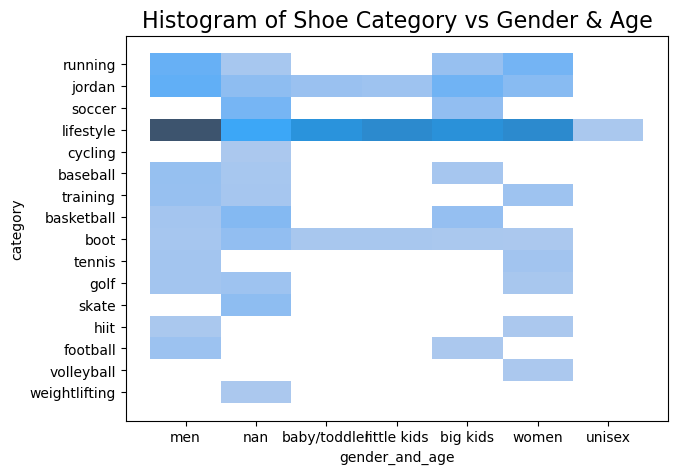

In [19]:
fig = plt.figure(figsize=(7,5))
sns.histplot(data=df_train, y='category', x='gender_and_age')
plt.title("Histogram of Shoe Category vs Gender & Age", size=16)
plt.show();

Text(0.5, 1.0, 'Boxplot of Shoe Category vs Price')

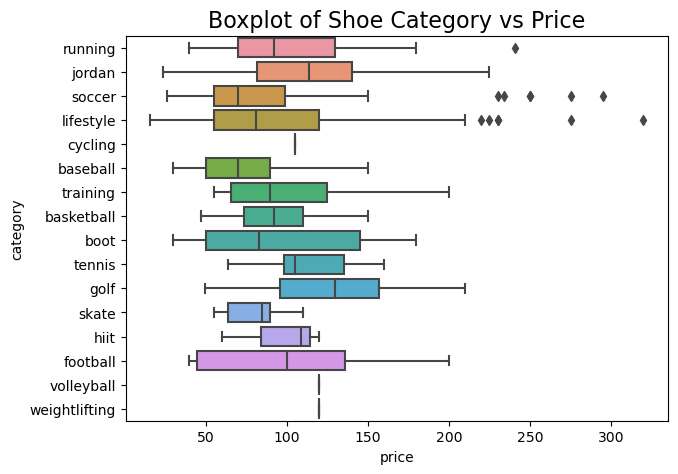

In [20]:
fig = plt.figure(figsize=(7,5))
sns.boxplot(data=df_train, y='category', x='price');
plt.title("Boxplot of Shoe Category vs Price", size=16)

Text(0.5, 1.0, 'Histogram of Gender & Age vs Price')

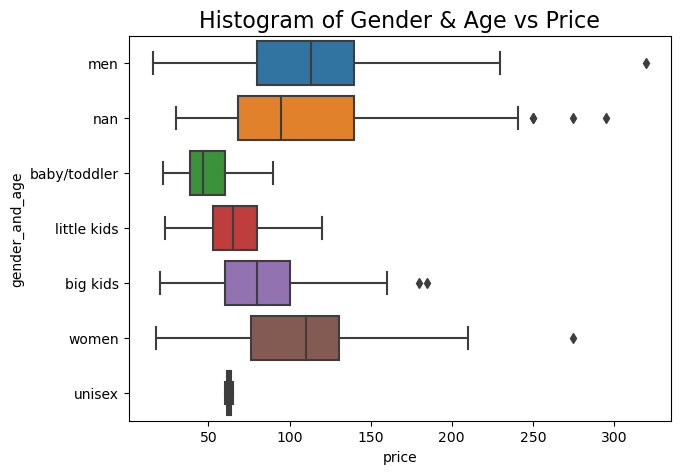

In [21]:
fig = plt.figure(figsize=(7,5))
sns.boxplot(data=df_train, y='gender_and_age', x='price');
plt.title("Histogram of Gender & Age vs Price", size=16)

In [22]:
non_text_columns = ['category', 'gender_and_age', 'n_color', 'rating', 'n_reviews', 'price']

array([[<AxesSubplot:xlabel='n_color', ylabel='n_color'>,
        <AxesSubplot:xlabel='rating', ylabel='n_color'>,
        <AxesSubplot:xlabel='n_reviews', ylabel='n_color'>,
        <AxesSubplot:xlabel='price', ylabel='n_color'>],
       [<AxesSubplot:xlabel='n_color', ylabel='rating'>,
        <AxesSubplot:xlabel='rating', ylabel='rating'>,
        <AxesSubplot:xlabel='n_reviews', ylabel='rating'>,
        <AxesSubplot:xlabel='price', ylabel='rating'>],
       [<AxesSubplot:xlabel='n_color', ylabel='n_reviews'>,
        <AxesSubplot:xlabel='rating', ylabel='n_reviews'>,
        <AxesSubplot:xlabel='n_reviews', ylabel='n_reviews'>,
        <AxesSubplot:xlabel='price', ylabel='n_reviews'>],
       [<AxesSubplot:xlabel='n_color', ylabel='price'>,
        <AxesSubplot:xlabel='rating', ylabel='price'>,
        <AxesSubplot:xlabel='n_reviews', ylabel='price'>,
        <AxesSubplot:xlabel='price', ylabel='price'>]], dtype=object)

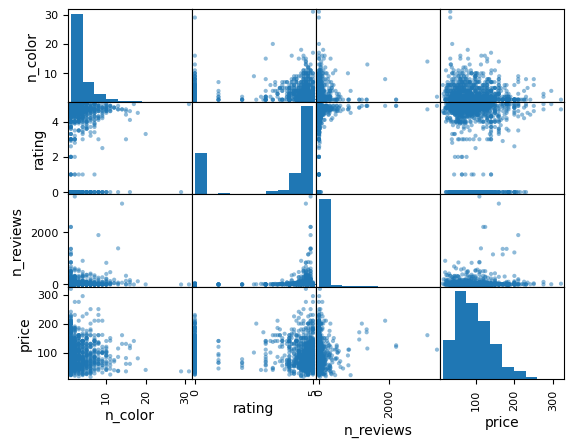

In [23]:
pd.plotting.scatter_matrix(df_train[non_text_columns]) 

<Figure size 700x500 with 0 Axes>

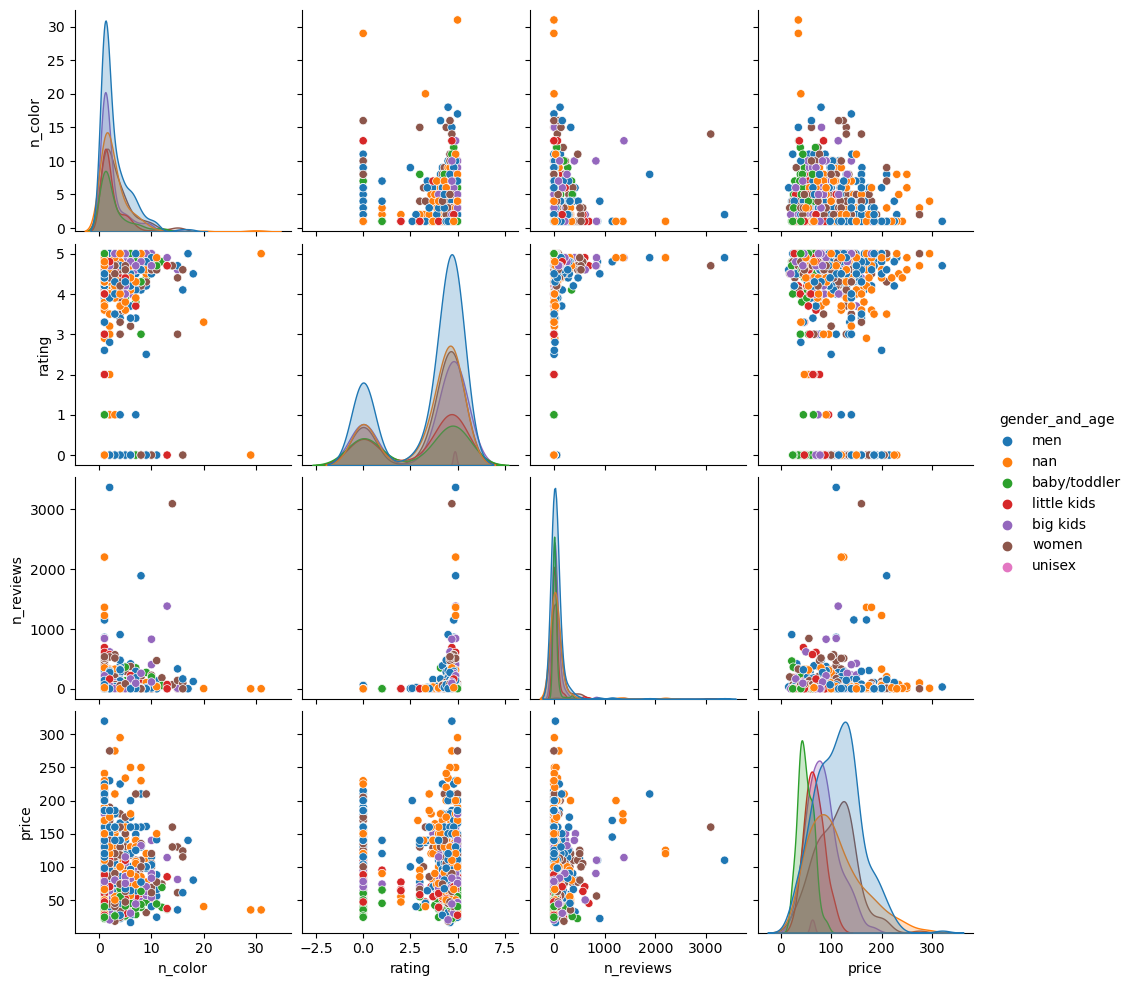

In [24]:
fig = plt.figure(figsize=(7,5))
sns.pairplot(df_train[non_text_columns], hue='gender_and_age',dropna=False)
plt.show();

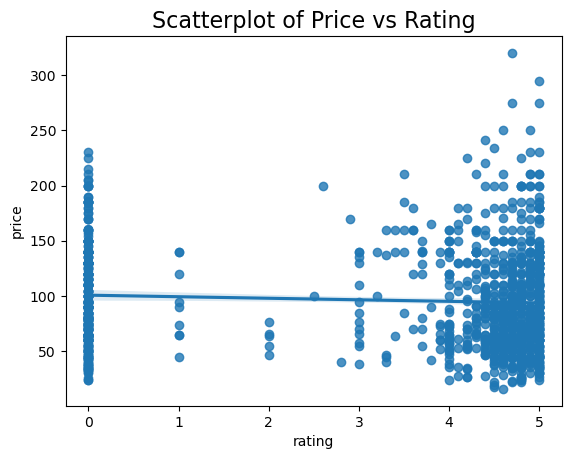

In [25]:
sns.regplot(data=df_train, x='rating', y='price',lowess=False, )
plt.title("Scatterplot of Price vs Rating", size=16)
plt.show();

<AxesSubplot:xlabel='n_color', ylabel='price'>

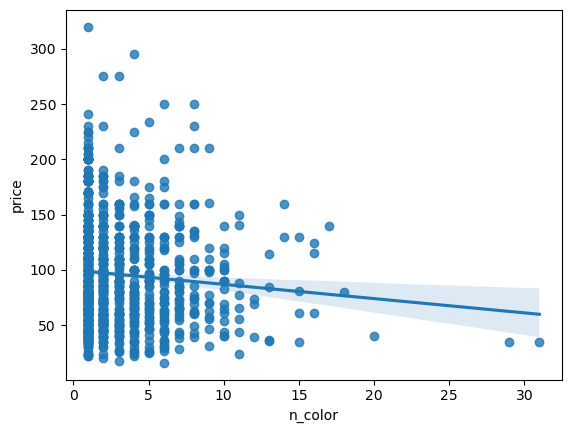

In [26]:
sns.regplot(data=df_train, x='n_color', y='price')

<h5>Exploratory data analysis on word based features of train data set</h5>

In [27]:
def find_token_names(column_names):
    word_features = []
    non_word_columns = ['model_', 'short_description', 'category', 'gender_and_age', 'n_color', 'rating', 'n_reviews', 'price']
    for name in column_names:
        if name not in non_word_columns:
            word_features.append(name)
    return word_features
            
token_names = find_token_names(df_train.columns)                                                                                                   

In [28]:
# find the most frequent 20 words
freq_words_20 = df_train[token_names].sum(axis=0).sort_values(ascending=False).head(20).index

# find 20 words which are most correlated with the price columns
corr_words_price = df_train.corr().loc[token_names, 'price']
highest_corr_words_20 = corr_words_price.sort_values(ascending=False).head(20)

In [29]:
print(f"The top 20 correlation values between the words and the price: \n \n {highest_corr_words_20}")

The top 20 correlation values between the words and the price: 
 
 air           0.264020
premium       0.157152
completely    0.144044
hatfield      0.144044
receive       0.144044
fitadapt      0.144044
form          0.144044
save          0.144044
lie           0.144044
tinker        0.144044
panel         0.134997
pair          0.134857
forefoot      0.133736
jordan        0.130910
personal      0.130395
full          0.129808
speed         0.129780
adapt         0.129265
twitchy       0.127980
km            0.127980
Name: price, dtype: float64


Text(0.5, 1.0, 'The most correlated 20 words vs correlation values')

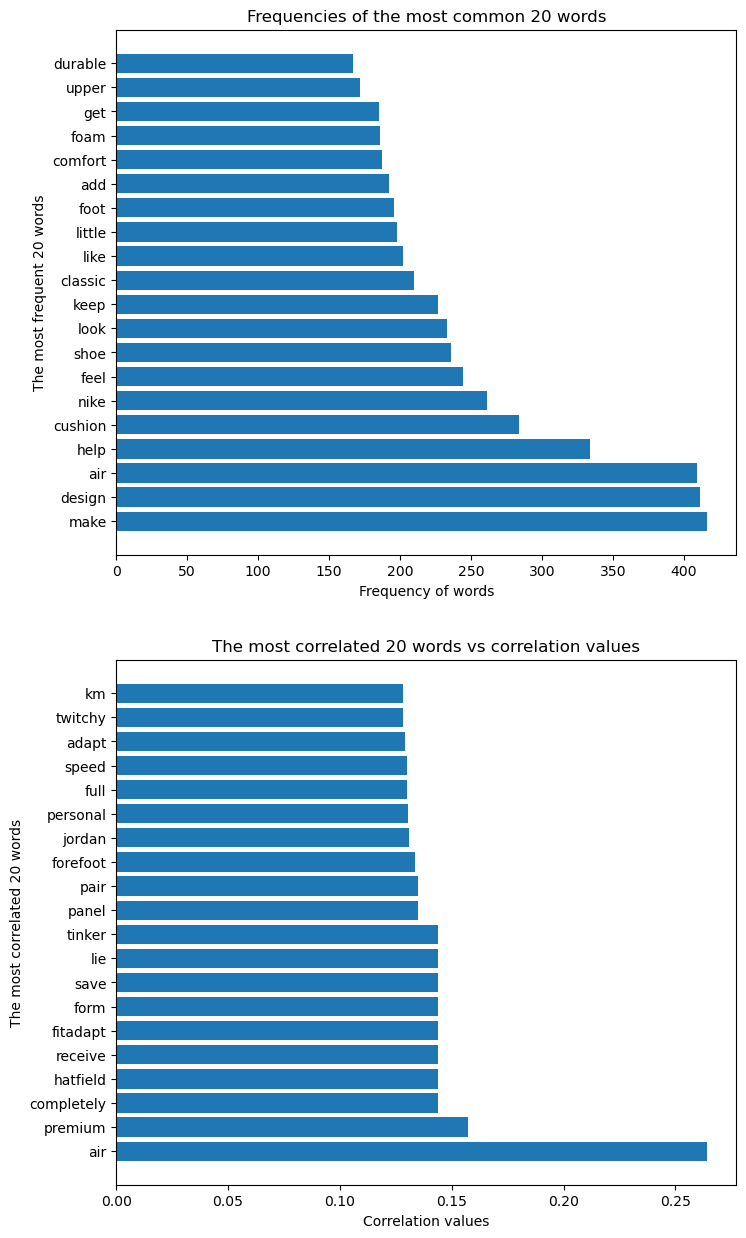

In [30]:
# visualise the most frequent 20 words and their frequency 
fig, ax = plt.subplots(2, 1, figsize=(8, 15))
ax[0].barh(df_train[freq_words_20].sum(axis=0).index, df_train[freq_words_20].sum(axis=0))
ax[0].set_xlabel("Frequency of words")
ax[0].set_ylabel("The most frequent 20 words")
ax[0].set_title("Frequencies of the most common 20 words")
#visualize the 20 words has the most correlation with the price
ax[1].barh(highest_corr_words_20.index, highest_corr_words_20.values)
ax[1].set_xlabel("Correlation values")
ax[1].set_ylabel("The most correlated 20 words")
ax[1].set_title("The most correlated 20 words vs correlation values")

<a id="models"></a>

## 5. Baseline Model on Most Correlated Tokens
[Return to Table of Contents](#contents)

In [31]:
chosen_token_names = highest_corr_words_20.index
chosen_token_names

Index(['air', 'premium', 'completely', 'hatfield', 'receive', 'fitadapt', 'form', 'save', 'lie', 'tinker', 'panel', 'pair', 'forefoot', 'jordan', 'personal', 'full', 'speed', 'adapt', 'twitchy', 'km'], dtype='object')

#### Decision Tree

In [32]:
X_train, X_test, y_train, y_test = df_train[chosen_token_names], df_test[chosen_token_names], df_train['price'], df_test['price']

In [33]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1167, 20), (1167,), (292, 20), (292,))

In [34]:
train_error, test_error = [], []
max_depths = range(1, 100)

for depth in max_depths:
    tree = DecisionTreeRegressor(max_depth=depth)
    tree.fit(X_train, y_train)
    train_error.append(mean_squared_error(tree.predict(X_train), y_train))
    test_error.append(mean_squared_error(tree.predict(X_test), y_test))

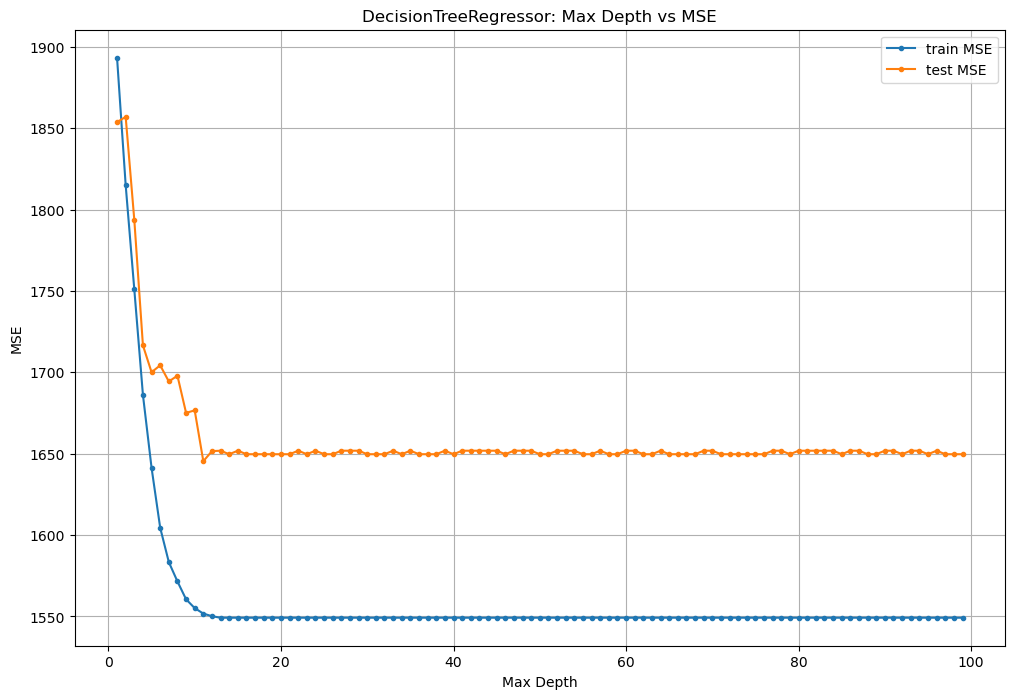

In [35]:
plt.figure(figsize=(12, 8))
plt.plot(max_depths, train_error, ".-", label="train MSE")
plt.plot(max_depths, test_error, ".-", label="test MSE")
plt.title("DecisionTreeRegressor: Max Depth vs MSE")
plt.xlabel("Max Depth")
plt.ylabel("MSE")
plt.grid()
plt.legend()

#### Random Forest

In [36]:
train_error, test_error = [], []
max_depths = range(1, 100)

for depth in max_depths:
    tree = RandomForestRegressor(max_depth=depth)
    tree.fit(X_train, y_train)
    train_error.append(mean_squared_error(tree.predict(X_train), y_train))
    test_error.append(mean_squared_error(tree.predict(X_test), y_test))

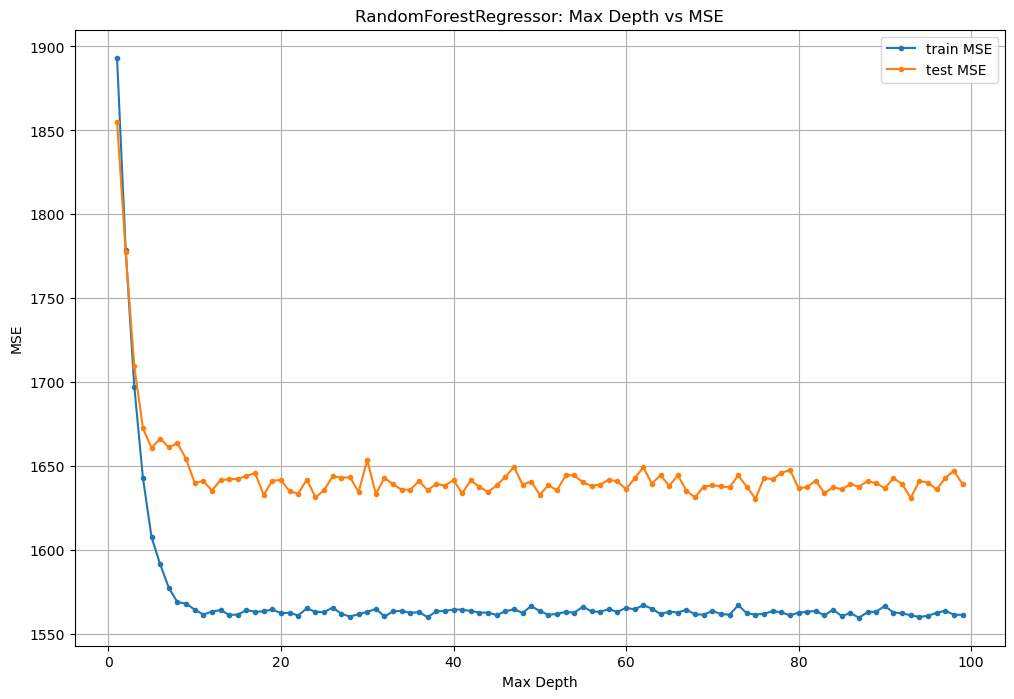

In [37]:
plt.figure(figsize=(12, 8))
plt.plot(max_depths, train_error, ".-", label="train MSE")
plt.plot(max_depths, test_error, ".-", label="test MSE")
plt.title("RandomForestRegressor: Max Depth vs MSE")
plt.xlabel("Max Depth")
plt.ylabel("MSE")
plt.grid()
plt.legend()

In [38]:
depth = 30

tree = RandomForestRegressor(max_depth=depth)
tree.fit(X_train, y_train)

print(mean_squared_error(tree.predict(X_train), y_train), mean_absolute_error(tree.predict(X_train), y_train))
print(mean_squared_error(tree.predict(X_test), y_test), mean_absolute_error(tree.predict(X_test), y_test))

1565.4551109921158 30.9059113746346
1626.1099501294082 30.906262751474433


In [39]:
train_error, test_error = [], []
max_depths = range(1, 100)

for depth in max_depths:
    tree = RandomForestRegressor(max_depth=depth)
    tree.fit(X_train, y_train)
    train_error.append(mean_absolute_error(tree.predict(X_train), y_train))
    test_error.append(mean_absolute_error(tree.predict(X_test), y_test))

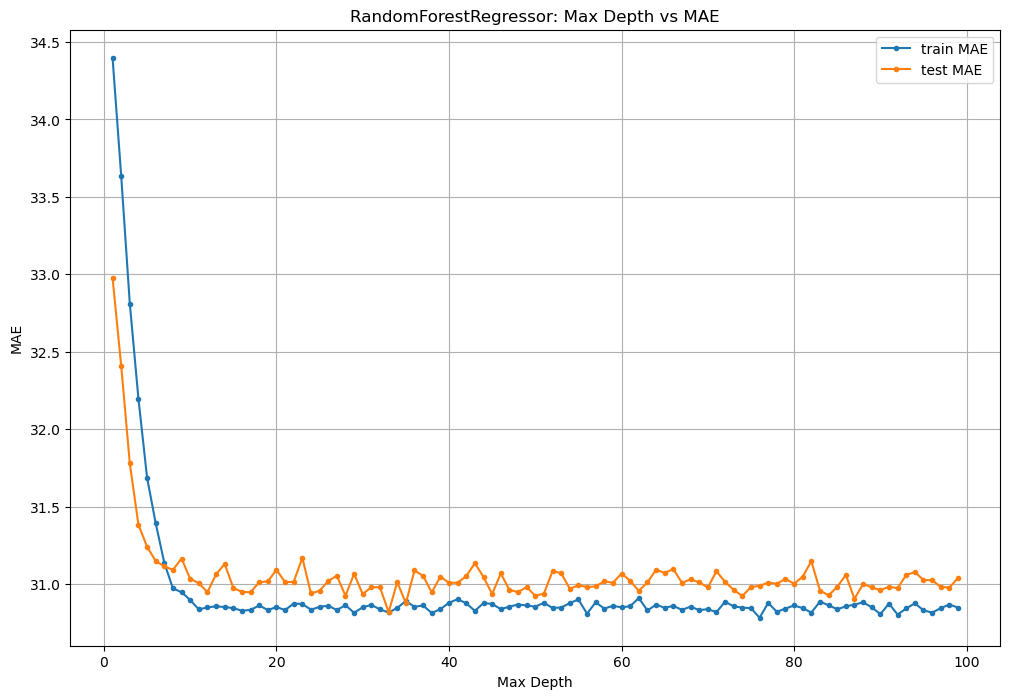

In [40]:
plt.figure(figsize=(12, 8))
plt.plot(max_depths, train_error, ".-", label="train MAE")
plt.plot(max_depths, test_error, ".-", label="test MAE")
plt.title("RandomForestRegressor: Max Depth vs MAE")
plt.xlabel("Max Depth")
plt.ylabel("MAE")
plt.grid()
plt.legend()

<a id="question"></a>

## 6. Final Conclusions
[Return to Table of Contents](#contents)

Model's accuracy will depend on the quality and completeness of the data available. Unfortunately, however, There was no public dataset with current and rich enough information to support building predictions.

For this reason, the scraping procedure will be developed more to acquire the entire Nike shoe dataset from their website (www.nike.com). The plan is to extract all the information available by invoking the API embedded in the Nike search engine. This will make the task repeatable and consistent. In addition, we will encapsulate the code as a class that can be used independently from our project.

Following this design, the extraction process will be automated as a pipeline (MLOps).




<a id="references"></a>

## 7. References
[Return to Table of Contents](#contents)

#### 1. Mercari Price Suggestion Challenge
In 2018, Mercari launched a Kaggle competition with prize money of $100,000. Over 2000 teams competed. Mercari is a buying and selling market comparable to other platforms like eBay. Mercari's challenge is similar to our own and is well summarized in the competition's opening statement:

*"It can be hard to know how much something’s really worth. Small details can mean big differences in pricing. For example, one of these sweaters cost \\$335 and the other cost \\$9.99. Can you guess which one’s which?"*

![](https://storage.googleapis.com/kaggle-media/competitions/mercari/mercari_comparison.png)

In the Mercari dataset, it was discovered that 'brand_name' was an important feature. Given that product prices are heavily affected by the brand, it is likely that a shoe's model could also have a significant impact on the price. It is worth examining this competition's results for potential strategies.

https://www.kaggle.com/c/mercari-price-suggestion-challenge/overview

#### B. Introduction to Bag-of-Words (BoW) and Term Frequency-Inverse Document Frequency (TF-IDF)
This article discusses the creation of vectors from text and introduces text representation using the BoW and TF-IDF approaches. Much of the data we are scraping is textual (e.g. shoe style, description) and thus BoW may be a useful technique to represent text numerically for analysis and modeling, in particular long strings. 

With BoW, a vocabulary of the unique words is first built, then their occurences/presence in a string are marked numerically as a vector. However, some potential drawbacks with the approach include generation of sparse matrices (i.e. contains too many zeros) and inconsitent vocabulary size.

Meanwhile, TF-IDF attempts to measure word importance by multiplying the term frequency (TF) (number of times a specific term appears in a document divided by the total number of terms in the document) by the inverse document frequency (IDF) (log of the number of documents divided by the number of documents with a specific term), yielding scores for our vocabulary.

While BoW vectors are easy to interpret, it seems TF-IDF tends to perform better in models. These techniques may be valuable as we attempt to find patterns and quantify our textual data.

https://www.analyticsvidhya.com/blog/2020/02/quick-introduction-bag-of-words-bow-tf-idf/


#### C. Vurvey Releases New Footwear Industry Data, Shows 99\% of Consumers Value Inclusivity
This article references a study, which although not large, provides some potential clues about drivers of shoe purchases. In particular, the study cited found that most respondents "want to purchase from brands that make them feel valued, included, and supported in the brand experience." Nike, which our data was derived from, was referenced as a top performing brand based on consumer sentiment of inclusivity.

Is it possible to isolate key terms in our data that can be associated with inclusivity? Can it be reasonably determined if a given Nike shoe "scores" relatively higher on inclusivity compared to others and whether there is any relationship to price levels? Identifying some custom patterns may be key to making more sense of our data and potentially producing a viable model.

https://vurvey.co/resources/customer-experience/consumers-buy-from-inclusive-brands/